In [227]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

In [228]:
#функция, возвращающая коэффициенты многочлена МНК
def LeastSquaresCoefs(x, y, m): 
    a = np.zeros((m + 1, m + 1))
    b = np.zeros(m + 1)
    s = np.zeros(2 * m + 1)
    
    for i in range(len(x)):
        buffer = y[i]              
        for j in range(m + 1):
                b[j] += buffer
                buffer *= x[i]               
        buffer = 1
        for j in range(2 * m + 1):
            s[j] += buffer
            buffer *= x[i]
            
    for i in range(m + 1):
        for j in range(m + 1):
            a[i, j] = s[i + j]
            
    return np.linalg.solve(a, b)

#функция, возвращающая значение многочлена МНК в точке 
def LeastSquares(coef, x0):                   
    m = len(coef) - 1
    polynom = coef[m]
    for j in range(m):
        polynom = polynom * x0 + coef[m - j - 1]
    return polynom

#метод минимальных поправок
def Solve(A, b, eps): 
    n = A.shape[0]
    B = np.zeros((n, n))
    for i in range(n):
        B[i][i] = A[i][i]
    x = np.zeros(n)
    fl = True
    
    while fl:
        r = A @ x - b
        w = np.linalg.inv(B) @ r
        v = np.linalg.inv(B) @ A @ w
        t = np.dot((A @ w), w) / np.dot(v, (A @ w))
        x_prev = x
        x = np.linalg.inv(B) @ (B @ x - t * r)
        fl = np.linalg.norm(x - x_prev) > eps
        
    return x

#коэффициенты формулы левых прямоугольников
def LeftRiemannSum(j):    
    if j == n - 1:
        return 0
    else:
        return h

#норма ядра -- используется для проверки единственности решения и нахождения
#связи невязки и погрешности
def KNorm(a, b, K):
    return np.sqrt(integrate.dblquad(lambda x, t: np.abs(K(x, t)) ** 2, a, b, lambda x: a, lambda x: b)[0])

#Евклидова норма вектора
def EuclideanNorm(x):
    s = 0
    n = x.shape[0]
    for i in range(n):
        s += x[i] ** 2
    return np.sqrt(s)

#решение интегрального уравнения Фредгольма второго рода
def IntegralEquation(K, a, b, h, param = 1, f = None): 
    #составляем матрицы для СЛАУ
    n = int((b - a) / h) + 1
    x = np.linspace(a, b, n)  
    
    #задаем матрицу B
    B = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            B[i][j] = param * LeftRiemannSum(j) * K(x[i], x[j])
    E = np.eye(len(B))  
    
    #вычисляем матрицу A
    A = E - B 
    
    #задаем данные для правой части системы
    x_data = np.array([0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3])
    y_data = np.array([8, 7.482, 7.098, 6.813, 6.602, 6.446, 6.331, 6.245, 6.128, 6.134, 5.82]) 
    
    #составляем вектор правой части: 
    #если f != None, то F -- функция, заданная аналитически
    F = np.zeros(n)
    for i in range(n):
        if f is None:
            F[i] = LeastSquares(LeastSquaresCoefs(x_data, y_data, 2), x[i])
        else:
            F[i] = f(x[i])
    
    #решаем СЛАУ методом минимальных поправок с заданной точностью   
    u = Solve(A, F, eps)
    #u = np.linalg.solve(A, F)
    
    #вычисляем норму ядра
    k_norm = KNorm(a, b, K)
    #вычисляем коэффициент С2
    C2 = 1 / (1 - k_norm)

    #задаем вектор невязки, интеграл будем вычислять, используя формулу
    #левых прямоугольников
    r = np.zeros(n)
    for i in range(n):
        r[i] = u[i] - F[i] - param * sum([LeftRiemannSum(j) * K(x[i], x[j]) * u[j] for j in range(n)])

    #вычислим Евклидову норму для полученного вектора невязки
    res = C2 * EuclideanNorm(r)
    
    return u, res

In [229]:
#тестовый пример 1
a = 0
b = 1                       
h = 0.01                
n = int((b - a) / h) + 1    
param = 0.5
eps = 1e-6

def Solution1(x): #точное решение
    return x
def K1(x, t): #ядро
    return x * t
def f1(x): #правая часть
    return (5 / 6) * x

||u - u*|| <= 1.946590122141595e-09


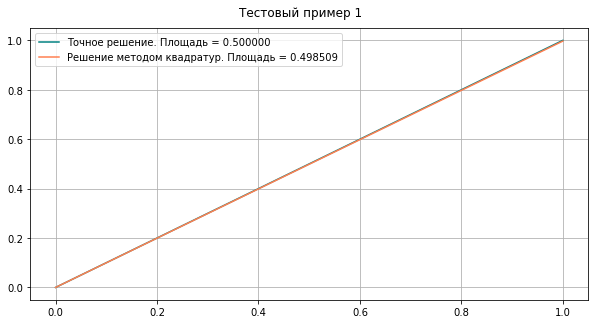

In [230]:
x_data = np.linspace(a, b, n)
y_data, r_data = IntegralEquation(K1, a, b, h, param, f1)

fig, axs = plt.subplots(1, 1, figsize=(10,5))
axs.plot(x_data, Solution1(x_data), color='teal', label=f'Точное решение. Площадь = {np.trapz(Solution1(x_data), x_data):.6f}')
axs.plot(x_data, y_data, color='coral', label=f'Решение методом квадратур. Площадь = {np.trapz(y_data, x_data):.6f}')
plt.suptitle('Тестовый пример 1', y=0.94)
plt.legend()
plt.grid()

||u - u*|| = 0.01734034229802168


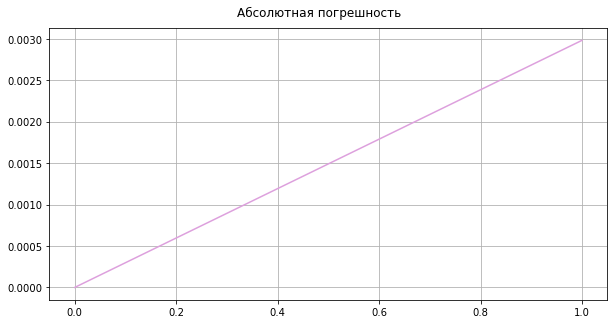

In [231]:
fig, axs = plt.subplots(1, 1, figsize=(10,5))
axs.plot(x_data, np.abs(Solution1(x_data) - y_data), color='plum')
plt.suptitle('Абсолютная погрешность', y=0.94)
plt.grid()

In [232]:
#тестовый пример 2
a = 0
b = 1                       
h = 0.01                
n = int((b - a) / h) + 1    
param = 0.5
eps = 1e-6

def Solution2(x): #точное решение
    return np.sin(np.math.pi * x) + 2 / (np.math.pi)
def K2(x, t): #ядро
    return 1
def f2(x): #правая часть
    return np.sin(np.math.pi * x)

||u - u*|| <= inf


<ipython-input-228-dd18fe14a788>:107: RuntimeWarning: divide by zero encountered in double_scalars
  C2 = 1 / (1 - k_norm)


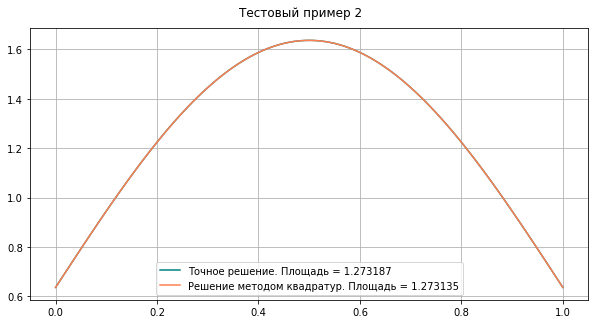

In [233]:
x_data = np.linspace(a, b, n)
y_data, r_data = IntegralEquation(K2, a, b, h, param, f2)

fig, axs = plt.subplots(1, 1, figsize=(10,5))
axs.plot(x_data, Solution2(x_data), color='teal', label=f'Точное решение. Площадь = {np.trapz(Solution2(x_data), x_data):.6f}')
axs.plot(x_data, y_data, color='coral', label=f'Решение методом квадратур. Площадь = {np.trapz(y_data, x_data):.6f}')
plt.suptitle('Тестовый пример 2', y=0.94)
plt.legend()
plt.grid()

||u - u*|| = 0.0005263849703784143


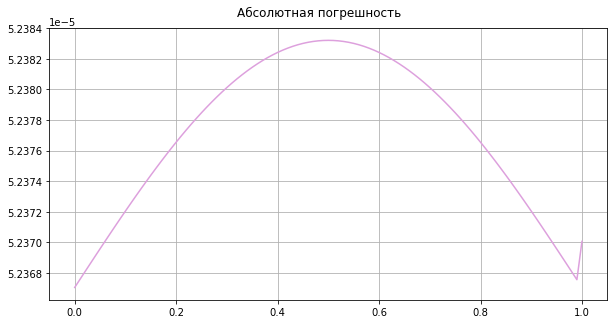

In [234]:
fig, axs = plt.subplots(1, 1, figsize=(10,5))
axs.plot(x_data, np.abs(Solution2(x_data) - y_data), color='plum')
plt.suptitle('Абсолютная погрешность', y=0.94)
plt.grid()

In [235]:
#исходные данные
a = 0
b = 3                
h = 0.01
n = int((b - a) / h) + 1
eps = 1e-6
alpha = 1
beta = 2

def K(x, t): #ядро
    return 1 / (1 + np.exp(abs(x - t)))

Оценка погрешности: ||u - u*|| <= 4.4088042281908743e-07


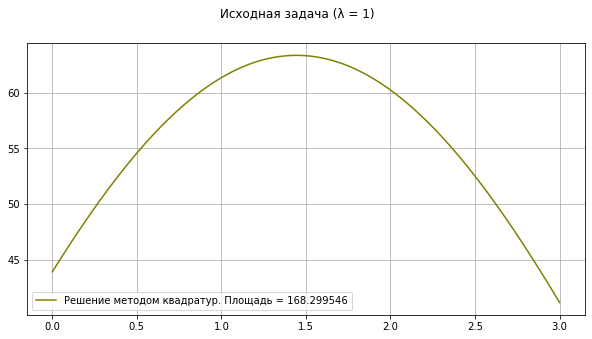

In [241]:
x_data = np.linspace(a, b, n)
y_data, r_data = IntegralEquation(K, a, b, h)

fig, axs = plt.subplots(1, 1, figsize=(10,5))
area = np.trapz(y_data, x_data)
axs.plot(x_data, y_data, color='olive', label=f'Решение методом квадратур. Площадь = {np.trapz(y_data, x_data):.6f}')
plt.suptitle('Исходная задача (λ = 1)', y=0.98)
plt.legend()
plt.grid()

print("Оценка погрешности: ||u - u*|| <=", r_data)

In [247]:
y_data, r_data = IntegralEquation(K, a, b, h, 1.2)
print("Оценка погрешности: ||u - u*|| <=", r_data)

Оценка погрешности: ||u - u*|| <= 38.621656241177085


0 , 0 Оценка погрешности: ||u - u*|| <= 4.4088042281908743e-07
0 , 1 Оценка погрешности: ||u - u*|| <= 38.621656241177085
1 , 0 Оценка погрешности: ||u - u*|| <= 4.8685081457552765e-05
1 , 1 Оценка погрешности: ||u - u*|| <= 1.7189690566186077e-05
2 , 0 Оценка погрешности: ||u - u*|| <= 5.150020853684956e-05
2 , 1 Оценка погрешности: ||u - u*|| <= 0.000863423832123382
Максимальное значение:
Параметр λ = [1.  1.2],  Площадь = 168.2995.


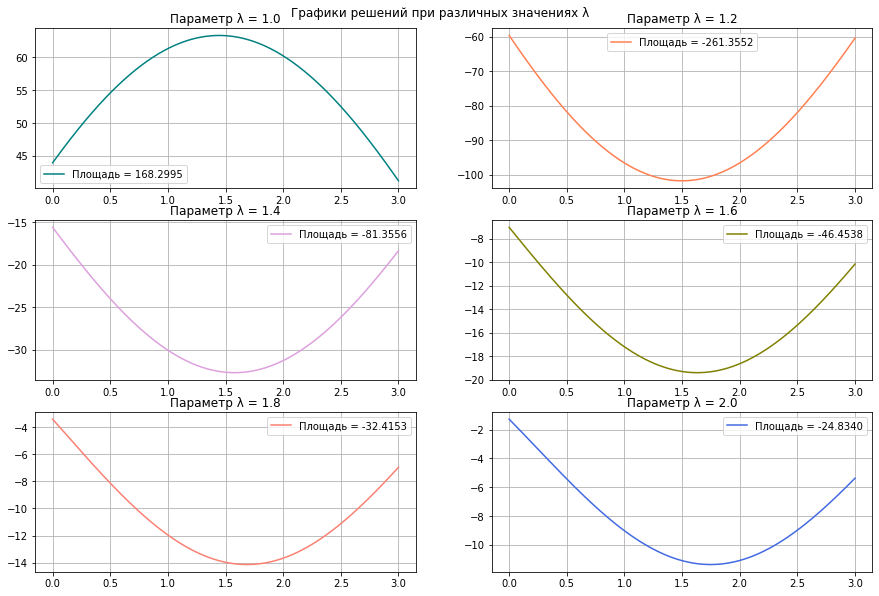

In [245]:
params = np.linspace(alpha, beta, 6) #1 1.2 1.4 1.6 1.8 2

colors = ('teal', 'coral', 'plum', 'olive', 'salmon', 'royalblue', 'pink', 'grey', 'darkorchid', 'turquoise')

params = np.reshape(params, (-1, 2))
colors = np.reshape(colors, (-1, 2))
areas = []

fig, axs = plt.subplots(3, 2, figsize=(15,10))
for i in range(params.shape[0]):
    for j in range(params.shape[1]):
        y_data, r_data = IntegralEquation(K, a, b, h, params[i][j])
        areas.append(np.trapz(y_data, x_data))
        axs[i][j].plot(x_data, y_data, color=colors[i][j], label=f'Площадь = {areas[-1]:.4f}')
        axs[i][j].set_title(f'Параметр λ = {params[i][j]}')
        axs[i][j].legend()
        axs[i][j].grid()
        
        print(i, ",", j, "Оценка погрешности: ||u - u*|| <=", r_data)
        
plt.suptitle('Графики решений при различных значениях λ', y=0.91)

lambdas = np.reshape(params, (-1))
print('Максимальное значение:', 
      f'Параметр λ = {params[areas.index(max(areas))]},  Площадь = {max(areas):.4f}.', sep='\n')

4.055762344526953
[15.70504254 15.85837613 16.00876185 16.15618633 16.30063649 16.44209953
 16.58056294 16.7160145  16.8484423  16.97783471 17.10418038 17.22746829
 17.34768768 17.46482812 17.57887947 17.68983188 17.7976758  17.90240201
 18.00400155 18.10246581 18.19778645 18.28995546 18.37896511 18.464808
 18.54747703 18.62696541 18.70326665 18.7763746  18.84628338 18.91298744
 18.97648156 19.03676081 19.09382057 19.14765654 19.19826475 19.24564151
 19.28978349 19.33068762 19.3683512  19.40277181 19.43394735 19.46187604
 19.48655643 19.50798737 19.52616802 19.54109788 19.55277675 19.56120474
 19.5663823  19.56831017 19.56698943 19.56242147 19.55460797 19.54355096
 19.52925278 19.51171607 19.49094379 19.46693923 19.43970598 19.40924795
 19.37556936 19.33867474 19.29856895 19.25525714 19.20874478 19.15903767
 19.1061419  19.05006387 18.9908103  18.92838821 18.86280494 18.79406813
 18.72218571 18.64716596 18.56901741 18.48774895 18.40336973 18.31588921
 18.22531718 18.1316637  18.0349391

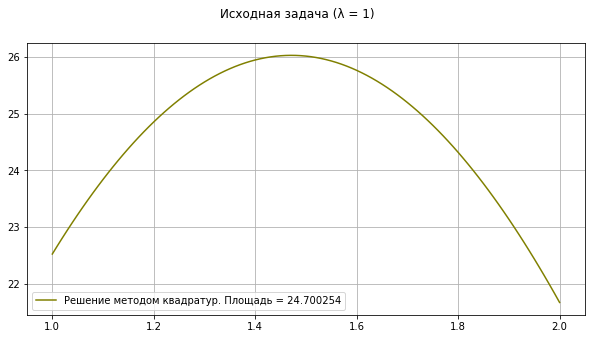

In [144]:
K = lambda x, t: np.exp(-1 * np.abs(x - t))
a, b = 1, 2
h = 0.01
n = int((b - a) / h) + 1
lambd, eps = 1, 1e-6
alpha, beta = 0.2, 0.7

x_data = np.linspace(a, b, n)
y_data, r_data = IntegralEquation(K, a, b, h)

fig, axs = plt.subplots(1, 1, figsize=(10,5))
area = np.trapz(y_data, x_data)
axs.plot(x_data, y_data, color='olive', label=f'Решение методом квадратур. Площадь = {np.trapz(y_data, x_data):.6f}')
plt.suptitle('Исходная задача (λ = 1)', y=0.98)
plt.legend()
plt.grid()

print("||u - u*|| <=", r_data)